<a href="https://colab.research.google.com/github/Riyan-Dev/Automated-Glaucoma-Detection-using-Optic-Disc-and-Cup-Segmentation/blob/main/DIP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output
from sklearn.model_selection import train_test_split

In [9]:
ground_truth_path = "/content/drive/MyDrive/ground truths"
images_path = "/content/drive/MyDrive/images"

In [10]:
image_files = sorted(os.listdir(images_path))
ground_truth_files = sorted(os.listdir(ground_truth_path))

In [11]:
image_files = sorted([f for f in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, f))])
ground_truth_files = sorted([f for f in os.listdir(ground_truth_path) if os.path.isfile(os.path.join(ground_truth_path, f))])

In [12]:
# Verify alignment by printing pairs
for i in range(5):  # Example to check the first 5 pairs
    print(f"Image file: {image_files[i]}, Mask file: {ground_truth_files[i]}")

Image file: 1.png, Mask file: 1.tif
Image file: 10.png, Mask file: 10.tif
Image file: 100.png, Mask file: 100.tif
Image file: 11.png, Mask file: 11.tif
Image file: 12.png, Mask file: 12.tif


In [14]:
images = [cv2.imread(os.path.join(images_path, f)) for f in image_files]
ground_truths = [cv2.imread(os.path.join(ground_truth_path, f), cv2.IMREAD_GRAYSCALE) for f in ground_truth_files]

In [15]:
train_images, test_images, train_ground_truths, test_ground_truths = train_test_split(images, ground_truths, test_size=10, random_state=42)
print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")

Number of training images: 90
Number of testing images: 10


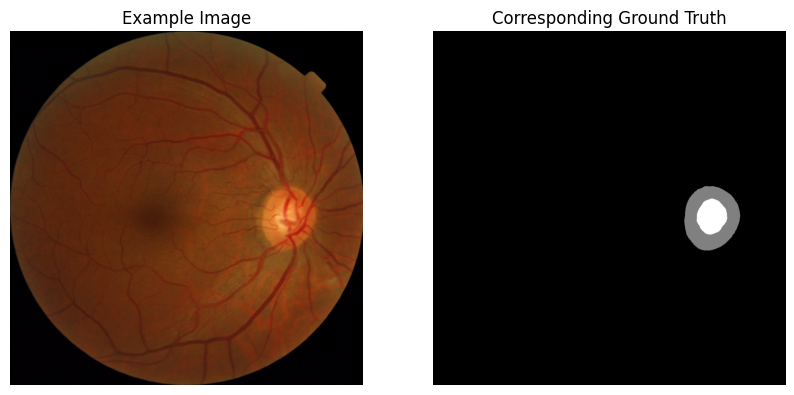

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
plt.title("Example Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(ground_truths[0], cv2.COLOR_BGR2RGB))
plt.title("Corresponding Ground Truth")
plt.axis('off')

plt.show()

In [17]:
TRAIN_LENGTH = 90
BATCH_SIZE = 8
BUFFER_SIZE = 100
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
width, height = 224, 224

In [23]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.float32)  # Assuming masks are already [0, 1] or need conversion similar to images
    return input_image, input_mask

def load_image_and_mask(image, mask):
    # Resize images if needed
    image = tf.image.resize(image, [height, width])

    # Ensure mask has a third dimension
    mask = tf.expand_dims(mask, axis=-1)  # Add a channels dimension
    mask = tf.image.resize(mask, [height, width])

    # Augment data with flipping
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    image, mask = normalize(image, mask)
    return image, mask

In [19]:
# Convert the lists to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_ground_truths))
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_ground_truths))

In [24]:
# Apply the load_image_and_mask function
train_ds = train_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

In [25]:
# Setting up the training dataset pipeline
train_ds = train_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# Setting up the testing dataset pipeline
test_ds = test_ds.batch(BATCH_SIZE)

In [27]:
for i in range(5):
    print(f"Image file: {image_files[i]}, Mask file: {ground_truth_files[i]}")

Image file: 1.png, Mask file: 1.tif
Image file: 10.png, Mask file: 10.tif
Image file: 100.png, Mask file: 100.tif
Image file: 11.png, Mask file: 11.tif
Image file: 12.png, Mask file: 12.tif


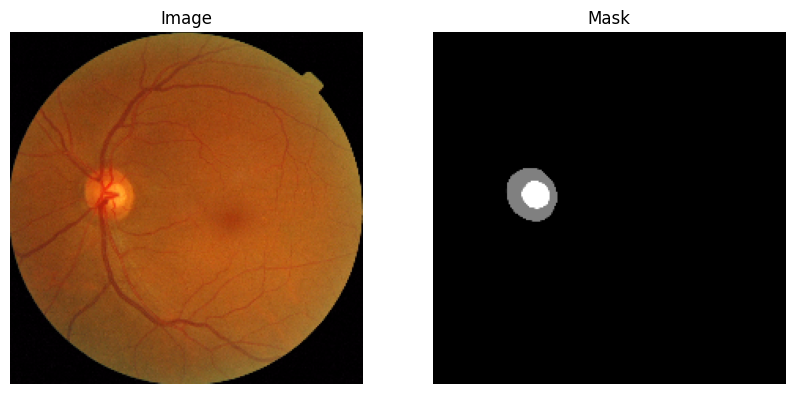

In [32]:
def display_sample(image, mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Mask')
    plt.imshow(mask, cmap='gray')
    plt.axis('off')

    plt.show()

# Fetch one batch from the dataset
for images, masks in train_ds.take(1):
    sample_image, sample_mask = images[0], masks[0]  # Take the first example in the batch
    display_sample(sample_image.numpy(), sample_mask.numpy())  # Convert tensors to numpy arrays for visualization